# Finds optical events in a video file

### Imports

In [1]:
# Python standard library
import sys
import os

# Scientific computing
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', '')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/oi/')
import optical_imaging as oi
import oi_file

# Jupyter
from IPython.display import HTML

### Load data

In [2]:
# Define file path
data_base_path = '/home/prestonh/Desktop/Research/cancer_cells/data'
date = '/11-30-2017'
particle_type = '/293-T_0'
channel_type = '/20-10x150_2'
file_index = '0'
file_path = data_base_path + date + particle_type + channel_type + '/oi/bin/test_camera_' + file_index

# Set output file path
output_file_path = file_path + '_events.json'

# Open video
res_x = 384
res_y = 112
fps = 250000
exp = 5
oi_vid = oi_file.Video(file_path, res_x, res_y, fps, exp)

### Functions

In [3]:
blur_kernel = (15,15)

def preprocess_frame(frame, blur_kernel):
    
    # Scale
    frame = np.copy(frame/(np.sum(frame.flatten())/(frame.shape[0]*frame.shape[1])))
    
    # Gaussian blur
    frame = cv2.GaussianBlur(frame, blur_kernel, 0)
    
    frame = frame/np.mean(frame)
        
    return frame



In [4]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    if show:
        plt.show()

### Create template frame and check preprocessing

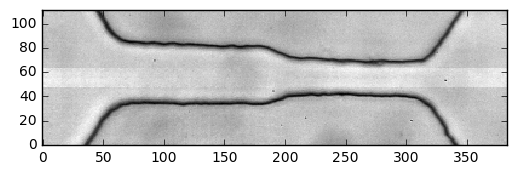

In [5]:
template_index = 1000

template_frame = oi_vid.get_frame(template_index)

plot_frame(template_frame)

### Find frame w/ particle

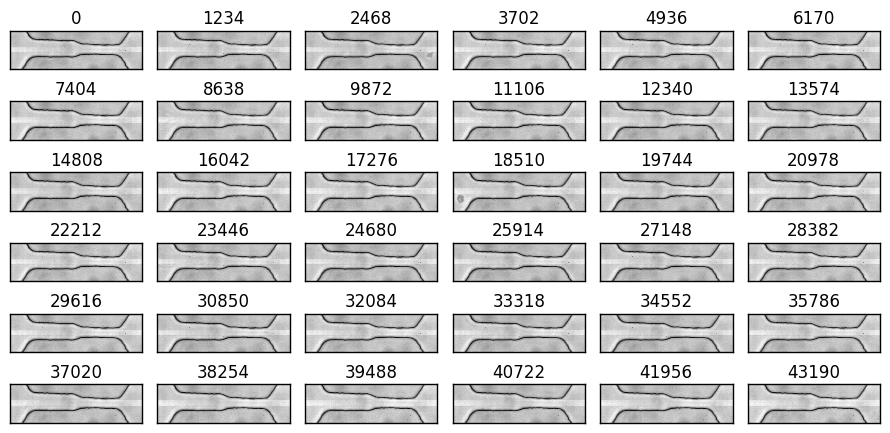

In [6]:
step = 1234
fig, axes = plt.subplots(6,6,figsize = (9,4.5))
for i in range(36):
    frame = oi_vid.get_frame(i*step)
    
    plt.sca(axes[i/6,i%6])
    plt.imshow(frame, cmap = 'gray', origin = 'lower')
    
    plt.title(str(i*step))
    plt.xticks([])
    plt.yticks([])
    
fig.tight_layout()
    
plt.show()

In [7]:
reload(oi)


index = 29616


# Parameters
threshold_difference = .035#.035
cluster_threshold = 200
blur = True
blur_kernel = (11,11)
diag = True
connect = True
connect_threshold = 25
negative_direction = 'neg'




# Get frames
template_frame = preprocess_frame(oi_vid.get_frame(template_index), blur_kernel)
raw_frame = oi_vid.get_frame(index)
frame = preprocess_frame(oi_vid.get_frame(index), blur_kernel)



# Get negative frame
neg_frame = template_frame - frame
if negative_direction == 'abs':
    neg_frame = np.abs(neg_frame)
elif negative_direction == 'pos':
    neg_frame *= -1


clusters = oi.find_clusters_iterative_percentage_based(frame, template_frame, threshold_difference = threshold_difference,\
                                             cluster_threshold = cluster_threshold, diag = diag, connect = connect, connect_threshold = connect_threshold, negative_direction = negative_direction)

### Test template subtraction

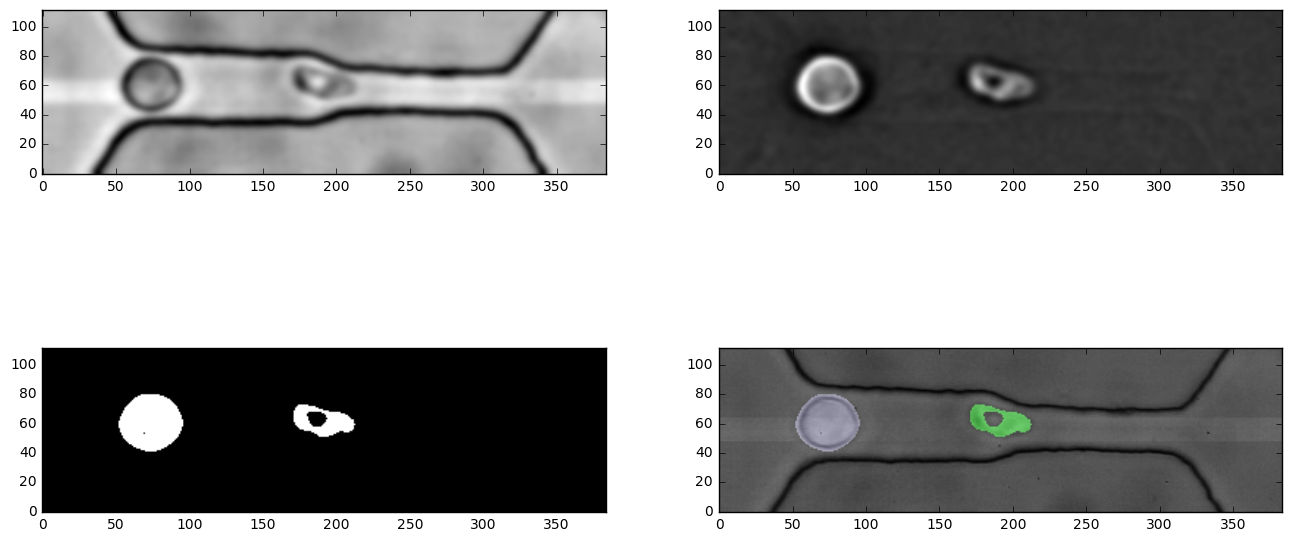

In [8]:
reload(oi)


index = 100


# Parameters
threshold_difference = .06#.035
cluster_threshold = 200
blur = True
blur_kernel = (11,11)
diag = True
connect = True
connect_threshold = 25
negative_direction = 'neg'




# Get frames
template_frame = preprocess_frame(oi_vid.get_frame(template_index), blur_kernel)
raw_frame = oi_vid.get_frame(index)
frame = preprocess_frame(oi_vid.get_frame(index), blur_kernel)



# Get negative frame
neg_frame = template_frame - frame
if negative_direction == 'abs':
    neg_frame = np.abs(neg_frame)
elif negative_direction == 'pos':
    neg_frame *= -1


clusters = oi.find_clusters_skimage(frame, template_frame, threshold_difference = threshold_difference,\
                                             cluster_threshold = cluster_threshold, diag = diag, negative_direction = negative_direction)






temp_neg_frame = np.copy(neg_frame)
temp_neg_frame[temp_neg_frame > threshold_difference] = 1
temp_neg_frame[temp_neg_frame <= threshold_difference] = 0



fig, axes = plt.subplots(2,2,figsize=(16,8))

# Raw image
plt.sca(axes[0,0])
plt.imshow(frame, cmap = 'gray', origin = 'lower')


# Negative
plt.sca(axes[0,1])
plt.imshow(neg_frame, cmap = 'gray', origin = 'lower')



# Thresholded negative
plt.sca(axes[1,0])
plt.imshow(temp_neg_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')

# Color frame
color_frame = np.zeros((frame.shape[0], frame.shape[1], 3))
for cluster in clusters:
    rand_color = [np.random.rand(), np.random.rand(), np.random.rand()]
    for pixel in cluster:
        color_frame[pixel[0], pixel[1],:] = rand_color

plt.sca(axes[1,1])
plt.imshow(raw_frame, cmap = 'gray', origin = 'lower')
plt.imshow(color_frame, alpha = 0.55, origin = 'lower')


plt.show()

### Find events

t:  21000 / 499925 	clusters: 0 	active: 0 	inactive: 173 	projected time: 73.4198320531  (min)


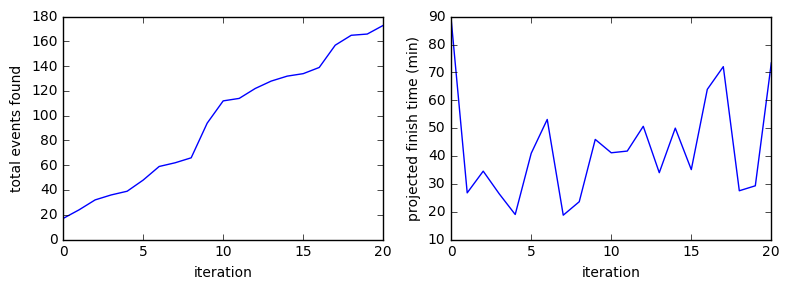

In [ ]:
reload(oi)
oi_events = oi.find_events(oi_vid, ti = 0, template_frame = oi_vid.get_frame(template_index),\
                           threshold_difference = threshold_difference, cluster_threshold = cluster_threshold,\
                           blur = blur, kernel = blur_kernel, diag = diag, connect = connect,\
                           connect_threshold = connect_threshold, negative_direction = negative_direction, normalize = True)

### Inspect trajectories

In [ ]:
fig = plt.figure(figsize = (20,12))
for i, event in enumerate(oi_events[:]):
    px = []
    py = []
    for detection in event._detections:
        px.append(detection._px)
        py.append(detection._py)
    plt.plot(px, py, lw = 2)

plt.imshow(template_frame, alpha=0.8, cmap = 'gray', origin = 'lower')
plt.xticks([])
plt.yticks([])

fig.tight_layout()


plt.show()

### Filter events

In [ ]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)

c0 = [50, 80]
c1 = [50, 43]
c2 = [375, 36] 
c3 = [375, 74]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage._length_microns = 150
oi_stage.plot_stage()

In [ ]:
for oi_event in oi_events:
    oi_event.get_channel_enter_exit_tf(oi_stage)

In [ ]:
filtered_oi_events = [oi_event for oi_event in oi_events if (oi_event._channel_enter_tf != None) and (oi_event._channel_exit_tf != None)]
print len(filtered_oi_events)

In [ ]:
thresh = 200
filtered_oi_events = [oi_event for oi_event in filtered_oi_events if len(oi_event._detections) < 200]
print len(filtered_oi_events)

In [ ]:
fig = plt.figure(figsize = (20,12))
for i, event in enumerate(filtered_oi_events[:]):
    px = []
    py = []
    for detection in event._detections:
        px.append(detection._px)
        py.append(detection._py)
    plt.plot(px, py, lw = 2)

plt.imshow(template_frame, alpha=0.8, cmap = 'gray', origin = 'lower')
plt.xticks([])
plt.yticks([])

fig.tight_layout()


plt.show()

In [ ]:
print(np.max([len(oi_event._detections) for oi_event in filtered_oi_events]))

In [ ]:
print np

### Save events

In [ ]:
print output_file_path

In [ ]:
oi_file.save_oi_events_json(output_file_path, filtered_oi_events)
print 'saved!'